# Invasive Ductal Carcinoma Classification and Targeting Model in Breast Histopathology

# Ishaan Jain
# 200968045

# 1. Introduction
## Motivation
Pathology is a method of identifying and diagnosing the cause of a disease through observation and analysis of cells or tissues. Because the existing pathology was based on the judgment made by the pathologist through the microscope, it was accompanied by problems such as high dependence on the individual ability of pathologists and the possibility of misdiagnosis due to high work intensity. In particular, in the modern era with massive data, the need for efficient and digital observation and analysis has increased. The image analysis technology of deep learning can help pathologists make decisions and solve existing problems. Histological diagnosis through pathological image analysis plays a very important role in determining the treatment and prognosis of breast cancer, the most common cancer in women. Therefore, the breast cancer pathology image analysis assistant program using deep learning will not only increase the efficiency of diagnosis, but also reduce the possibility of misdiagnosis, which will be of great help in the treatment and prognosis of many breast cancer patients.

## Goal
This project targets invasive ductal cancer, the most common of many breast cancer types.  
**The main goal is to design a deep learning model capable of classification prediction and location targeting of invasive ductal carcinoma through breast histopathology images.**

## Background knowledges
### 1. What is Invasive Ductal Carcinoma (IDC)

IDC refers to a condition in which cancer that begins in milk ducts has expanded and spread to surrounding tissues. IDC is a very common form, accounting for 80% of all breast cancer diagnoses. The main symptoms of IDC include the development of lumps or changes in the shape of the breast. However, most patients do not experience any specific signs or symptoms in the early stages of IDC, so many patients miss the time to be diagnosed and treated with IDC at an early stage [2]. Early detection of IDC is very important because if treatment is missed in a timely manner, cancer may metastasize through blood vessels or lymphatic vessels [3].

# 2. Package setup and data preparation


## Package settings

In [1]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import matplotlib.image as plt_img
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score

from os import listdir
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [2]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

 99% 3.07G/3.10G [00:25<00:00, 106MB/s] 
100% 3.10G/3.10G [00:25<00:00, 131MB/s]


In [3]:
!unzip \*.zip && rm*.zip

Streaming output truncated to the last 5000 lines.
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2301_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2351_class0.png  
  inflating: IDC_regular_

## Loading and storing the datasets
The whole image file has 162 whole mount slide images taken at 40x.  
There are 277,524 patch images with a size of 50 x 50 extracted from the entire image.  
Of these, 198,738 are IDC negative and 78,786 are IDC positive.  
The patient ID, class (0: non-IDC, 1: IDC), location path of the image file, x coordinate, y coordinate are collected from the patch image file and stored.  
(※ Due to the large capacity to use all the data, only a portion was used.)  

See the original site below for more details.  
https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images

In [4]:
def load_data(max_num = None, save = False, shuffle = True):
    base = '/content/IDC_regular_ps50_idx5'  # Root path including all files
    files = listdir(base)

    if max_num is None:
        max_num = len(files)
    if shuffle:
        files = np.random.choice(files, size = max_num)
        
    informations = []
    for patient_id in files[:max_num]:
        patient_path = base + '/' + patient_id
        column = ['ID', 'cancer', 'image_path', 'x_coor', 'y_coor']

        for target in range(2):
            class_path = patient_path + '/' + str(target)
            for image in listdir(class_path):
                info = []
                info.append(patient_id)                    # Patient ID
                info.append(target)                        # Class (0: non-IDC, 1: IDC)
                info.append(class_path + '/' + str(image)) # Image path

                # Decompose Image name to extract X and Y coordinates
                # 8863_idx5_x51_y1251_class0   -> '8863', 'id', '5', '', '51', '', '1251', 'class0'
                img = re.split('[x y _]', image)
                info.append(img[4]) # X coordinate
                info.append(img[6]) # Y coordinate
                informations.append(info)

    df = pd.DataFrame(np.array(informations), columns = column)
    df[['ID', 'cancer', 'x_coor', 'y_coor']] = df[['ID', 'cancer', 'x_coor', 'y_coor']].astype('int32')
    
    if save:
        df.to_csv('./data.csv')
    return df

data = load_data(max_num = 40)
print(data)


          ID  cancer                                         image_path  \
0      12749       0  /content/IDC_regular_ps50_idx5/12749/0/12749_i...   
1      12749       0  /content/IDC_regular_ps50_idx5/12749/0/12749_i...   
2      12749       0  /content/IDC_regular_ps50_idx5/12749/0/12749_i...   
3      12749       0  /content/IDC_regular_ps50_idx5/12749/0/12749_i...   
4      12749       0  /content/IDC_regular_ps50_idx5/12749/0/12749_i...   
...      ...     ...                                                ...   
42865  13687       1  /content/IDC_regular_ps50_idx5/13687/1/13687_i...   
42866  13687       1  /content/IDC_regular_ps50_idx5/13687/1/13687_i...   
42867  13687       1  /content/IDC_regular_ps50_idx5/13687/1/13687_i...   
42868  13687       1  /content/IDC_regular_ps50_idx5/13687/1/13687_i...   
42869  13687       1  /content/IDC_regular_ps50_idx5/13687/1/13687_i...   

       x_coor  y_coor  
0        2001    1301  
1         351    1901  
2        2651    2651  
3  

# 3. Exploratory analysis

## Comparing non-IDC vs IDC patches
I want to observe the characteristics of the IDC patch by comparing the images of the non-IDC patch and the IDC patch.

In [5]:
def image_plot(df, row, col, idx, label):
    fig, axes = plt.subplots(row, col, figsize = (col * 4, row * 4))
    fig.suptitle(label + ' patch Images', fontsize = 20)

    for i in range(row):
        for j in range(col):
            image = plt_img.imread(df.loc[idx[i*col + j], 'image_path'])
            axes[i][j].imshow(image)
            axes[i][j].grid(False)

def visualization(df, row, col, shuffle = True):
    postive = []
    negative = []
    if shuffle:
        positive = np.random.choice(df[df['cancer'] == 1].index.values, size = row * col, replace = False)
        negative = np.random.choice(df[df['cancer'] == 0].index.values, size = row * col, replace = False)

    else:
        postive = df[df['cancer'] == 1].index.values[:row * col]
        negative = df[df['cancer'] == 0].index.values[:row * col]

    image_plot(df, row, col, positive, 'IDC')
    image_plot(df, row, col, negative, 'non-IDC')

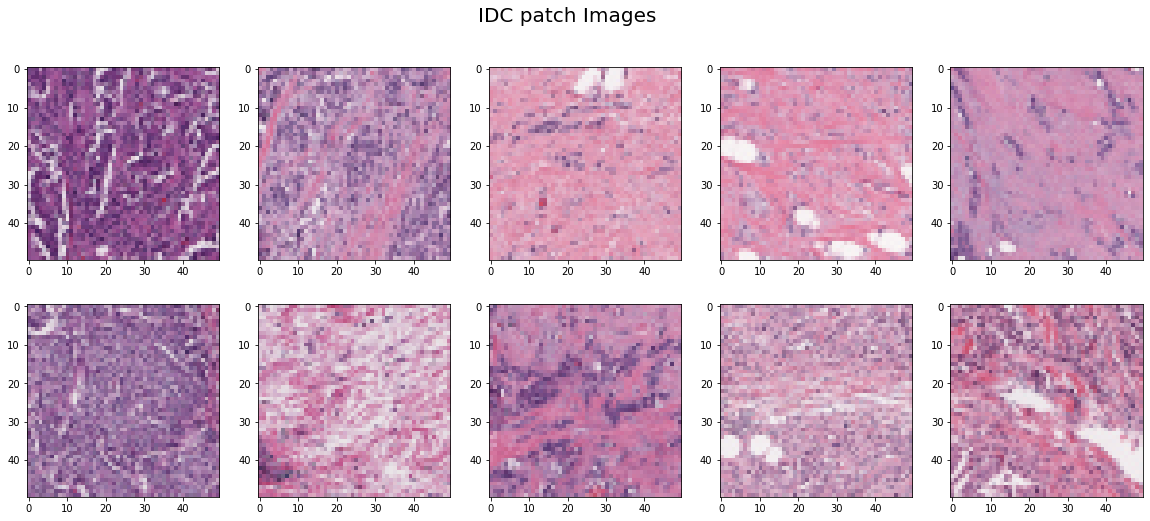

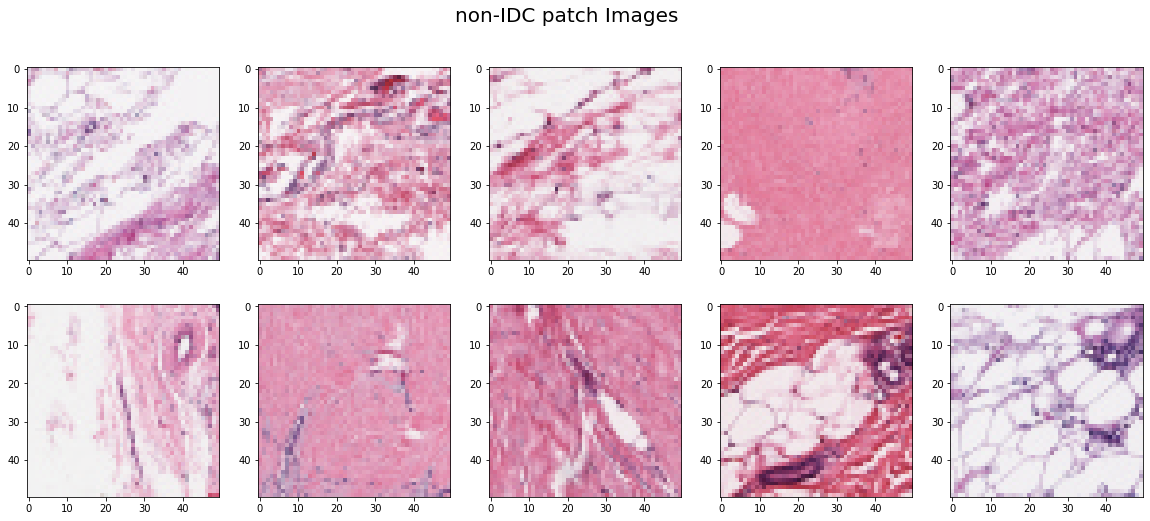

In [6]:
visualization(data, 2, 5)

**IDC patch images generally have a darker color than non-IDC patch images.**  
However, there are dark purple parts in the non-IDC patch images.  
These are expected to be a type of cancer other than IDC. These images can be a factor that lowers the accuracy of the prediction. 

## Visualising the IDC positions in each whole slice image
It is expressed as a dot map, and each point means one patch image.  
Based on the x and y coordinates of each patch image, the approximate location of the IDC can be quickly checked without actual image data.  
<span style="color: red">Red dots</span> correspond to <span style="color: red">IDC patches</span>, and <span style="color: blue">blue dots</span> correspond to <span style="color: blue">non-IDC patches</span>.

In [7]:
def simple_whole_tissue(df, row, col, shuffle = True):
    patient_ids = df['ID'].unique() 
    samples = []
    if shuffle:
        samples = np.random.choice(patient_ids, size = row * col, replace = False)
    else:
        samples = patient_ids[:row * col]

    target = 'cancer'

    # Plotting approximate whole slide image shape and IDC location with dots
    fig, axes = plt.subplots(row, col, figsize = (col*10, row *8))
    axes = axes.flatten()
    
    for i in range(row):
        for j in range(col):
            sns.scatterplot(data = df[df['ID'] == samples[i*col + j]], x = 'x_coor', y = 'y_coor', c = df[df['ID'] == samples[i*col + j]][target], cmap = 'coolwarm', s = 20, ax = axes[i*col + j])
            axes[i*col + j].set_title("Patient ID " + str(samples[i*col + j]), fontsize = 20)
            axes[i*col + j].set_xlabel("X coordinate", fontsize = 15)
            axes[i*col + j].set_ylabel("Y coordinate", fontsize = 15)

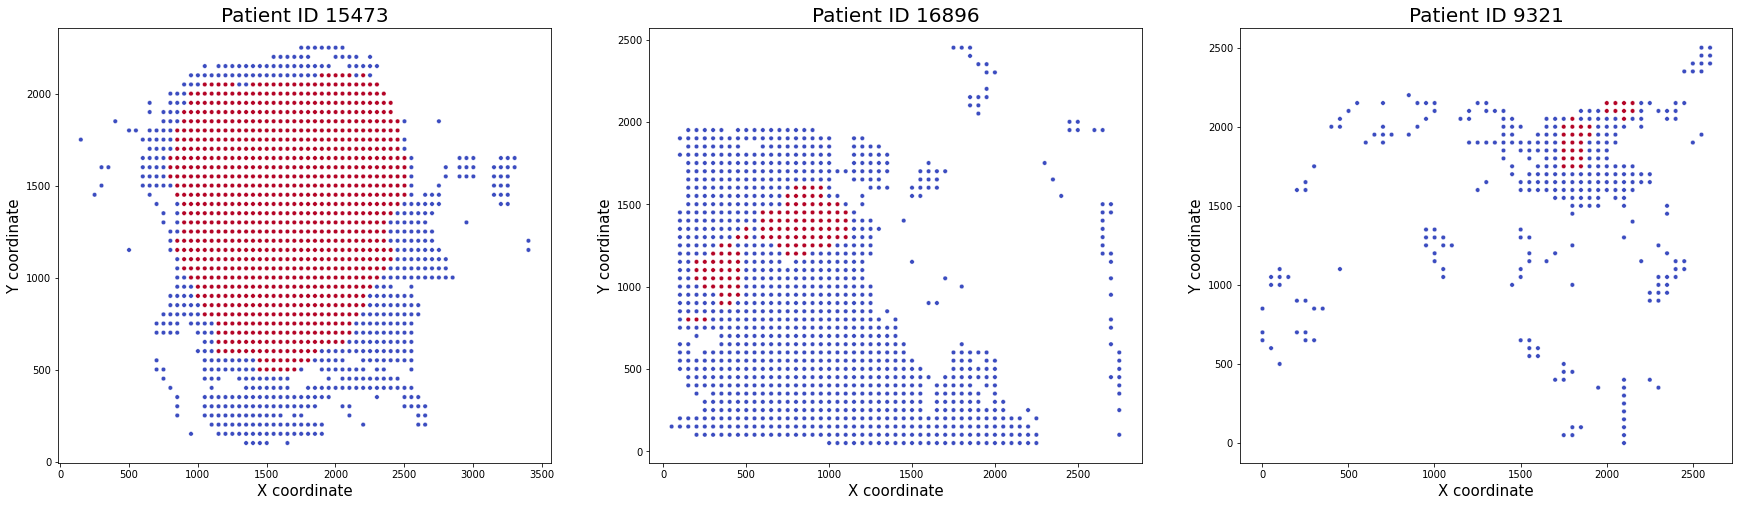

In [8]:
simple_whole_tissue(data, 1, 3)

The position corresponding to the IDC in the Whole slide image can be easily identified.  
It can be observed that the IDC parts are **clustered** together.   
That is, the location information of each patch is also required for IDC classification and prediction.

## Visualising the whole slice images

<span style="color: red">Red parts</span> correspond to <span style="color: red">IDC patches</span>, and <span style="color: blue">blue parts</span> correspond to <span style="color: blue">non-IDC patches</span>.  

For the whole slide image, patch images were loaded from data corresponding to a specific patient's id, and then combined based on the x and y coordinates corresponding to each patch image.  
IDC and non-IDC filters are based on the IDC information of each patch (corresponding to the 'cancer' column in the data, 0: non-IDC, 1: IDC).

In [9]:
def whole_slice_image(df, patient_id = None, pred = False, prob_criterion = 0):

    # Random selection when no specific patient ID is given
    if patient_id == None:
        patient_ids = df['ID'].unique()
        patient_id = np.random.choice(patient_ids, size = 1, replace = False)
    sample = df[df['ID'] == patient_id[0]]

    x_max = sample['x_coor'].max() - 1
    y_max = sample['y_coor'].max() - 1
    n_bins = 10

    # Create a matrix that can attach the entire tissue
    grid = 255 * np.ones((y_max + 50, x_max + 50, 3))  # Background tissue image
    mask = np.full((y_max + 50, x_max + 50, 1), -1)  # Color filter to mark IDC sites
    mask_pred = np.full((y_max + 50, x_max + 50, 1), -1).astype(np.float32) # Color filter to mark predicted IDC sites

    for n in sample.index:
        # Get image data
        image = plt_img.imread(sample.at[n, 'image_path'])
        height, width = image.shape[0], image.shape[1]
        x_start, y_start = sample.at[n, 'x_coor'] - 1, sample.at[n, 'y_coor'] - 1
        x_end, y_end = x_start + width, y_start + height
        # Fill the part corresponding to the coordinates with the data of the image.
        # (Similar to fitting pieces in a specific location)
        grid[y_start:y_end, x_start:x_end] = image

        # Set the value of the position corresponding to IDC to 1
        mask[y_start:y_end, x_start:x_end, 0] = sample.at[n, 'cancer']
        # Set the IDC predicted probability to the value of each location
        if pred and sample.at[n, 'probability'] > prob_criterion:
            mask_pred[y_start:y_end, x_start:x_end, 0] = sample.at[n, 'probability']
    
    y, x = np.mgrid[slice(0, y_max + 50, 1), slice(0, x_max + 50, 1)]
    cmap = plt.get_cmap('seismic')
        
    # Plotting whole slice Image
    fig, axes = plt.subplots(1, 2, figsize = (30, 20))

    if pred:
        z = [mask.reshape(y.shape), mask_pred.reshape(y.shape)]
        levels = [[-0.1, 0.5, 1], MaxNLocator(nbins = n_bins).tick_values(0, z[1].max())]
        titles = ['Breast tissue with red colored cancer Image of patient ' + str(patient_id[0]), 
                  '[Prediction] Breast tissue with predicted probability of IDC Image of patient ' + str(patient_id[0])]
        
        for i in range(2):
            im = axes[i].contourf(x, y, z[i], levels = levels[i], alpha = 0.4, cmap = cmap)
            axes[i].set_title(titles[i], fontsize = 20)
            divider = make_axes_locatable(axes[i])
            cax = divider.append_axes('right', size = '5%', pad = 0.05)
            plt.colorbar(im, cax = cax, cmap = cmap)
    else:
        z = mask.reshape(y.shape)
        im = axes[1].contourf(x, y, z, alpha = 0.4, levels = [-0.1, 0.5, 1], cmap = cmap)
        axes[0].set_title('Breast tissue Image of patient ' + str(patient_id[0]), fontsize = 20)
        axes[1].set_title('Breast tissue with red colored IDC Image of patient ' + str(patient_id[0]), fontsize = 20)
        divider = make_axes_locatable(axes[1])
        cax = divider.append_axes('right', size = '5%', pad = 0.05)
        plt.colorbar(im, cax = cax, cmap = cmap)

    for i in range(2):
         # Paint background tissue image
        axes[i].imshow(grid)
        axes[i].grid(False)
        axes[i].set_xlabel('X coordinate', fontsize = 15)
        axes[i].set_ylabel('Y coordinate', fontsize = 15)
        axes[i].invert_yaxis()

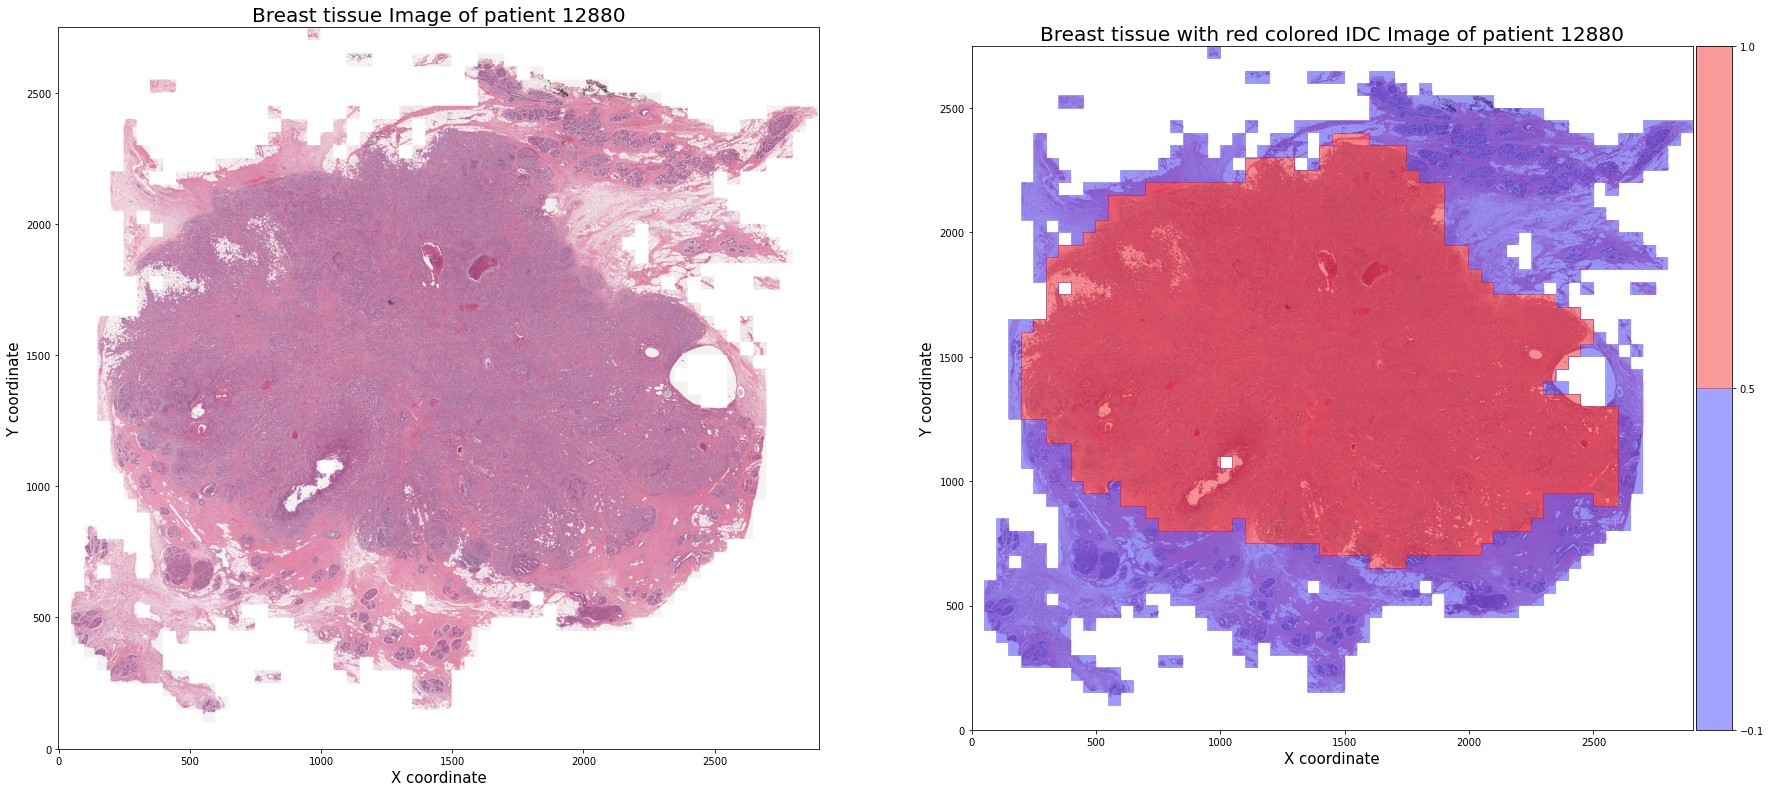

In [10]:
whole_slice_image(data)

The tissue in the red part corresponding to the IDC patch generally has a dark color.  
In this project, I aim to make predictions as similar to the picture on the right as possible by learning using deep learning.

# 4. Prepare training and testing datasets and train deep learning model
Training & testing datasets for deep learning learning are first **separated based on patient id**.  
**(training : testing = 3 : 1)**  
The reason for separating based on the patient's id is to exclude a specific id from learning for the purpose of improving the performance of the model in the future because there is a possibility that the whole slide image of a specific patient is inappropriate for learning.  
(Examples of incompatibility: When it is difficult to distinguish between iDC and non-IDC because the degree of staining is too severe or weak, when it is judged that the tissue is abnormally shaped and negatively affects learning)  
Based on the separated patient's ID, the patch images are loaded and prepared by transforming them into an ndarray (numpy array) form.

## Getting the image dataset from image path
Receives image data of a fixed size (50 x 50) from the image source path.  
(Images other than 50 x 50 size are excluded because there is a high possibility that they are edges of the whole slide image or the wrong part)  
The obtained image data is converted to ndarray and returned.

In [11]:
def get_img_array(img_path, size):
    images = []
    for img in img_path:
        img = keras.preprocessing.image.load_img(img, target_size = size)
        img = keras.preprocessing.image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        images.append(img)
    images = np.vstack(images)
    return images

## Spliting training and testing patient ids
Separate patient ids for use in training and testing.
And it gets the image data from each patient ID.


In [12]:
def get_train_test_data(df, save = False):
    patient_ids = df['ID'].unique()
    train_ids, test_ids = train_test_split(patient_ids) # Split for training and testing by patient ID
    print('Train patient IDs: ', train_ids)
    print('Test patient IDs: ', test_ids)

    # Copy dataframe corresponding to each ID
    train_set = df[df['ID'].apply(lambda x: x in train_ids)]
    test_set = df[df['ID'].apply(lambda x: x in test_ids)]

    size = (50, 50)
    
    train_x = get_img_array(train_set['image_path'], size)
    test_x = get_img_array(test_set['image_path'], size)
    train_y = train_set['cancer']
    test_y = test_set['cancer']

    if save:
        np.save('./X_train.npy',train_x)
        np.save('./X_test.npy',test_x)
        np.save('./y_train.npy',train_y)
        np.save('./y_test.npy',test_y)
    
    return (train_ids, test_ids), (train_x, train_y), (test_x, test_y)

In [13]:
(train_ids, test_ids), (X_train, y_train), (X_test, y_test) = get_train_test_data(data)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

Train patient IDs:  [16896 12818 10257 10275  9321  9123 10272 14321 15516 15473 12898 12880
 12905 12909 12896  9036 13691 12884 16569 14212  8864  9077 10299 16534
 12878 12933 10277]
Test patient IDs:  [ 8867  9383 13613 12820  9261 12824 12749  9226 13687  9075]
X_train shape:  (30469, 50, 50, 3)
y_train shape:  (30469,)
X_test shape:  (12401, 50, 50, 3)
y_test shape:  (12401,)


## Deep learning model training
The CNN part of **EfficientNetB2** is used and the **fully-connected network** part consists of **FC256-FC128-FC64**.

### Activation functions
- **'ReLU'** was used for the activation functions of the **remaining layers except for the last layer**.
- **The last layer used 'Sigmoid'** as an activation function for binary classification.

### Epochs
- **50**

### Loss function
- **Binary Corssentropy** is used as it must be classified as IDC or non-IDC

### Validation
- **20%** of the training dataset is used as validation

### Metrics
- **Loss, accuracy values**

### Optimizer
- Using **Adam** from Keras
- The **learning rate** is set to **0.001**

In [14]:
class Mymodel1(keras.Model):
    def __init__(self):
        super().__init__()
        self.base = keras.applications.EfficientNetB2(include_top = False, weights = 'imagenet', input_shape = (50, 50, 3))
        self.base.trainable = False
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(256, activation = 'relu')
        self.dense2 = layers.Dense(128, activation = 'relu')
        self.dense3 = layers.Dense(64, activation = 'relu')
        self.dense4 = layers.Dense(1, activation = 'sigmoid')

    def call(self, inputs):
        x = self.base(inputs)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.dense4(x)   
    
model = Mymodel1()

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

history = model.fit(X_train, y_train, epochs = 50, validation_split = 0.2)
keras.models.save_model(model, 'Mymodel')
model.summary()

31790344/31790344 [==============================] - 0s 0us/step
Epoch 1/50
762/762 [==============================] - 39s 29ms/step - loss: 0.4305 - accuracy: 0.8105 - val_loss: 0.2843 - val_accuracy: 0.8894
Epoch 2/50
762/762 [==============================] - 17s 22ms/step - loss: 0.3903 - accuracy: 0.8302 - val_loss: 0.2741 - val_accuracy: 0.9020
Epoch 3/50
762/762 [==============================] - 23s 30ms/step - loss: 0.3739 - accuracy: 0.8398 - val_loss: 0.2960 - val_accuracy: 0.8804
Epoch 4/50
762/762 [==============================] - 17s 22ms/step - loss: 0.3618 - accuracy: 0.8455 - val_loss: 0.3251 - val_accuracy: 0.8712
Epoch 5/50
762/762 [==============================] - 19s 25ms/step - loss: 0.3550 - accuracy: 0.8471 - val_loss: 0.2756 - val_accuracy: 0.8963
Epoch 6/50
762/762 [==============================] - 21s 28ms/step - loss: 0.3481 - accuracy: 0.8497 - val_loss: 0.2893 - val_accuracy: 0.8838
Epoch 7/50
762/762 [==============================] - 17s 22ms/step - l

Model: "mymodel1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 2, 2, 1408)       7768569   
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  1442048   
                                                                 
 dense_1 (Dense)             multiple                  32896     
                                                                 
 dense_2 (Dense)             multiple                  8256      
                                                                 
 dense_3 (Dense)             multiple                  65        
                                                                 
Total params: 9,251,834
Trainable params: 1,483,265
Non-tr

# 5. Evaluation of model performance

## Checking loss and accuracy scores during training
The loss value continuously decreases and the accuracy tends to increase continuously.  
This means that learning is progressing well.

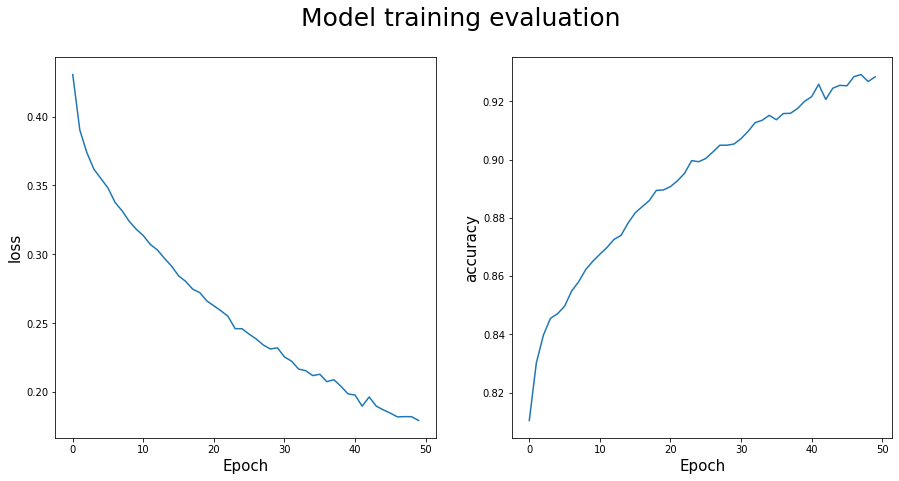

In [15]:
def check_loss_acc(history):
    fig, axes = plt.subplots(1, 2, figsize = (15, 7))
    eva = ['loss', 'accuracy']
    for i in range(2):
        sns.lineplot(data = history[eva[i]], ax = axes[i])
        axes[i].set_xlabel('Epoch', fontsize = 15)
        axes[i].set_ylabel(eva[i], fontsize = 15)
    plt.suptitle('Model training evaluation', fontsize = 25)

check_loss_acc(history.history)

## Checking loss and accuracy scores with testing dataset

In [16]:
model.evaluate(X_test, y_test)

388/388 [==============================] - 7s 18ms/step - loss: 0.4859 - accuracy: 0.8537


[0.48594290018081665, 0.8537214994430542]

## Obtaining the predictive probability scores of invasive ductal carcinoma
After obtaining the IDC prediction probability for each patch of test data, it is additionally stored in the data as a probability.

In [17]:
def prediction(X_test):
    y_pred = model.predict(X_test).flatten()

    pred_sample = data.loc[y_test.index, :]
    pred_sample['probability'] = y_pred
    return pred_sample

y_pred = prediction(X_test)
print(y_pred)

388/388 [==============================] - 9s 15ms/step
          ID  cancer                                         image_path  \
0      12749       0  /content/IDC_regular_ps50_idx5/12749/0/12749_i...   
1      12749       0  /content/IDC_regular_ps50_idx5/12749/0/12749_i...   
2      12749       0  /content/IDC_regular_ps50_idx5/12749/0/12749_i...   
3      12749       0  /content/IDC_regular_ps50_idx5/12749/0/12749_i...   
4      12749       0  /content/IDC_regular_ps50_idx5/12749/0/12749_i...   
...      ...     ...                                                ...   
42865  13687       1  /content/IDC_regular_ps50_idx5/13687/1/13687_i...   
42866  13687       1  /content/IDC_regular_ps50_idx5/13687/1/13687_i...   
42867  13687       1  /content/IDC_regular_ps50_idx5/13687/1/13687_i...   
42868  13687       1  /content/IDC_regular_ps50_idx5/13687/1/13687_i...   
42869  13687       1  /content/IDC_regular_ps50_idx5/13687/1/13687_i...   

       x_coor  y_coor   probability  
0    

## Confusion matrix

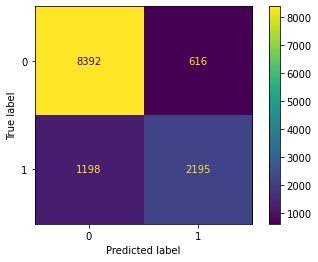

In [18]:
y_prediction = tf.round(y_pred['probability'])
y_true = y_pred['cancer']

disp = ConfusionMatrixDisplay.from_predictions(y_true, y_prediction)

## Checking area under curve with ROC curve
The prediction performance of the model can be evaluated through the Area Under Curve (AUC) in the ROC curve.  
The closer the AUC value to 1, the better the performance.

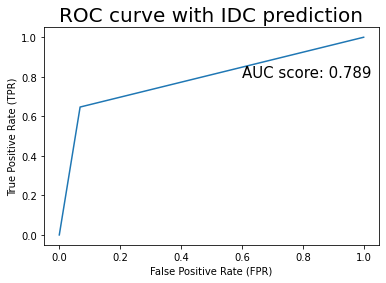

In [19]:
def roc(y_actual, y_score, title):
  fpr, tpr, threshold = roc_curve(y_actual, y_score)
  _, axe = plt.subplots()
  axe.plot(fpr, tpr)
  axe.set_xlabel('False Positive Rate (FPR)')
  axe.set_ylabel('True Positive Rate (TPR)')
  auc_score = roc_auc_score(y_actual, y_score)
  axe.text(0.6, 0.8, 'AUC score: {:.3f}'.format(auc_score), fontsize = 15)
  axe.set_title(title, fontsize = 20)

roc(y_test, y_prediction, 'ROC curve with IDC prediction')

## Probability map visualization of invasive ductal carcinoma
Image according to IDC prediction probability. Red color is determined as IDC and blue color is determined as non-IDC.  
The red distribution near the actual IDC area indicates that the IDC prediction was successful.  
**In general, the darker the region, the higher the probability of IDC seems to be predicted.**

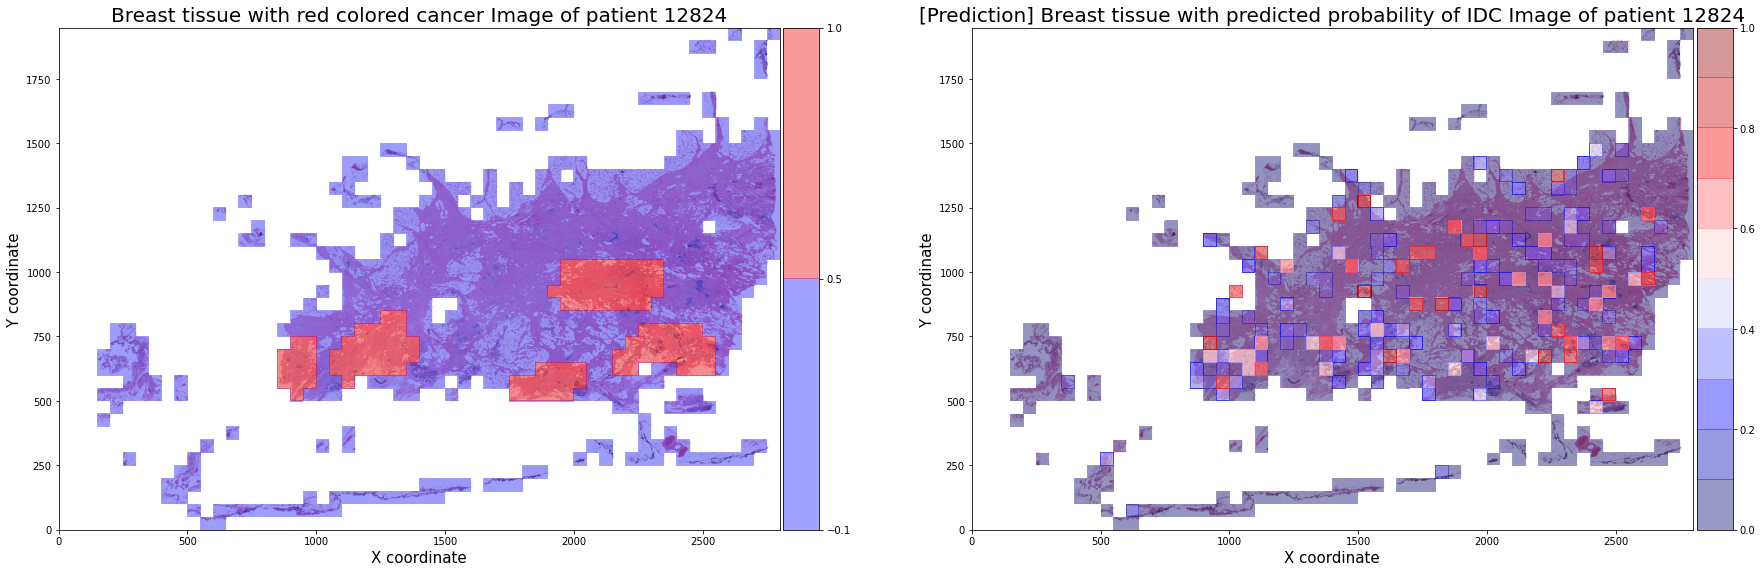

In [20]:
whole_slice_image(df = y_pred, pred = True)

## Probability map visualization of invasive ductal carcinoma in dot map
Image according to IDC prediction probability. Red color is determined as IDC and blue color is determined as non-IDC.  
The red distribution near the actual IDC area indicates that the IDC prediction was successful.  
The location of the IDC prediction area can be observed with a dot map.

In [21]:
def prob_dot_mapping(df, test_ids, patient_id = None, sample_num = 1):
    if patient_id == None:
        patient_id = np.random.choice(test_ids, size = sample_num, replace = False)

    # Plotting approximate whole slide image shape and IDC location with dots
    fig, axes = plt.subplots(sample_num, 2, figsize = (24, 8 * sample_num))
    axes = axes.flatten()

    for i in range(sample_num):
        sample = df[df['ID'] == patient_id[i]]
        for j in range(2):
            target = 'cancer' if j == 0 else 'probability'
        
            im = sns.scatterplot(data = sample, x = 'x_coor', y = 'y_coor', c = df[df['ID'] == patient_id[i]][target], cmap = 'coolwarm', s = 30, ax = axes[i*2 + j])
            axes[i*2 + j].set_title("Patient ID " + str(patient_id[i]), fontsize = 20)
            axes[i*2 + j].set_xlabel("X coordinate", fontsize = 15)
            axes[i*2 + j].set_ylabel("Y coordinate", fontsize = 15)
            norm = plt.Normalize(sample[target].min(), sample[target].max())
            sm = plt.cm.ScalarMappable(cmap = 'coolwarm', norm = norm)
            sm.set_array([])

            im.figure.colorbar(sm, ax = axes[i*2 + j])

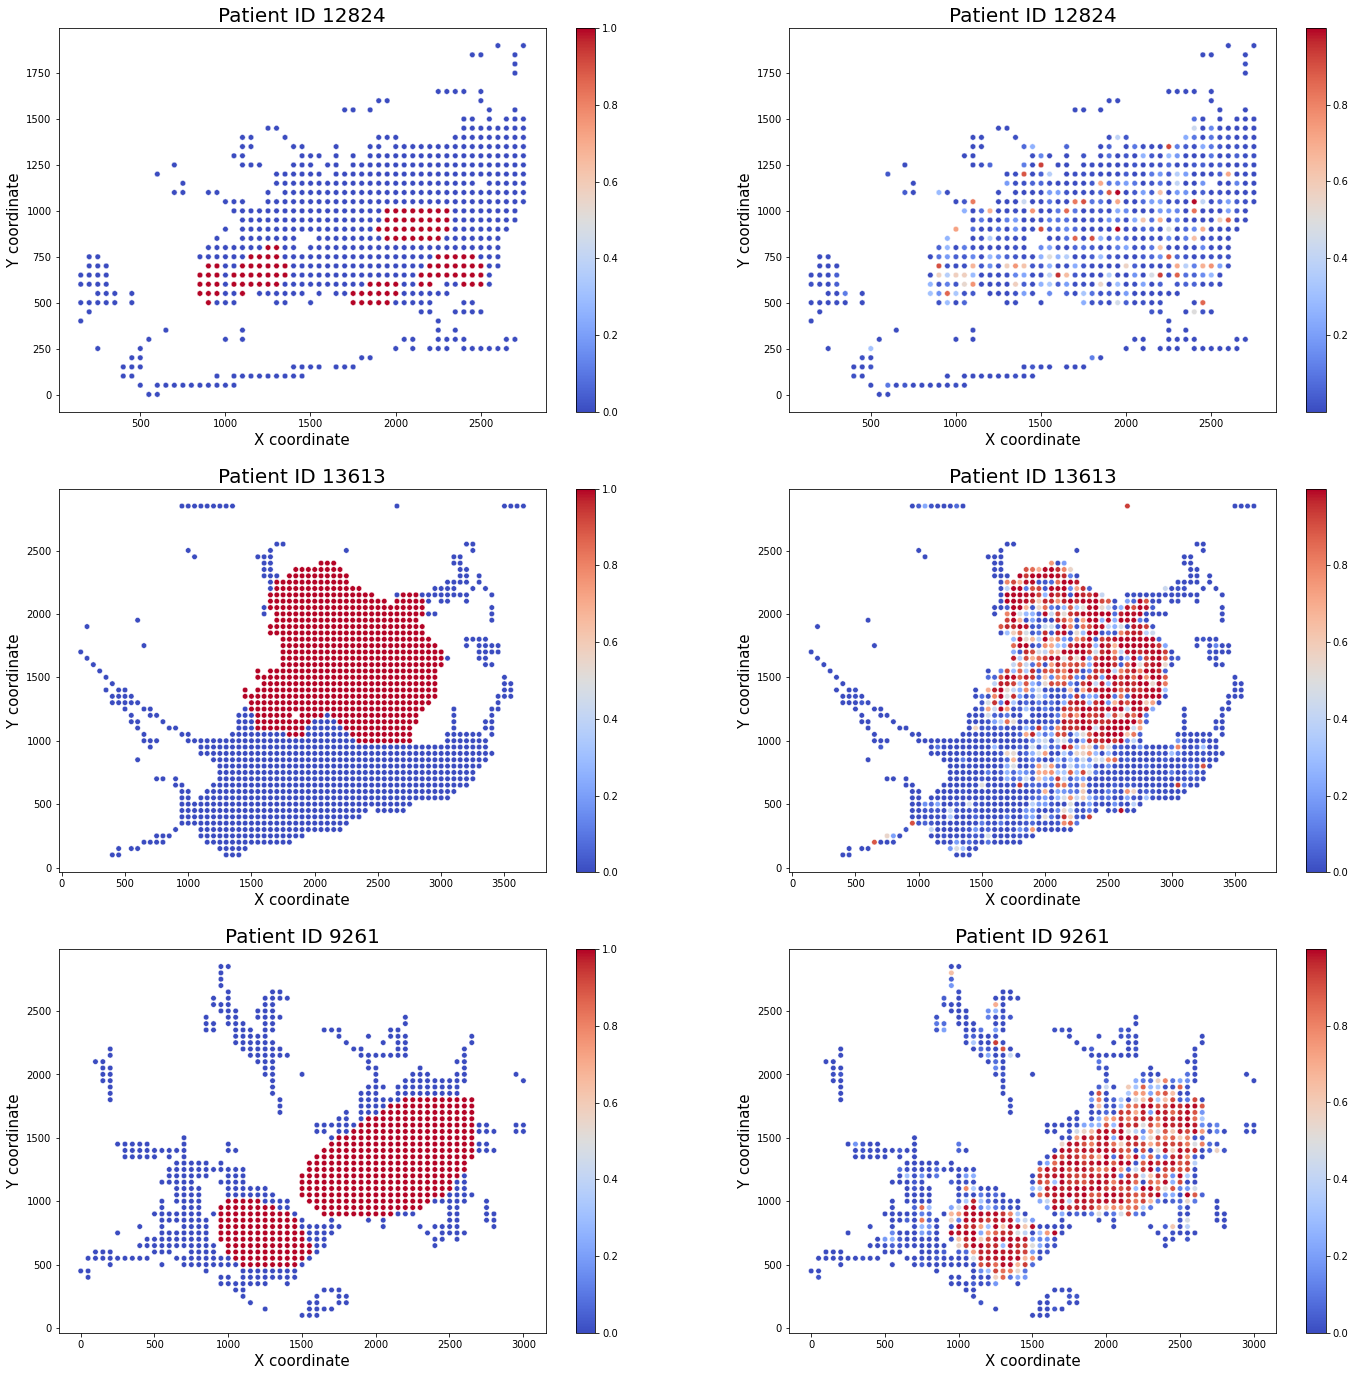

In [22]:
prob_dot_mapping(y_pred, test_ids, sample_num = 3)

# Result of IDC prediction
It can be seen that the predicted value near the IDC area is measured to be high, so that the predicted area of the IDC is similar to the actual IDC area.  
However, it does not form a smooth and uniform probability distribution and tends to spread disproportionately.  
In order to be commercialized and target a specific location, it is necessary to improve the probability distribution more gently.

# 6. Invasive ductal carcinoma probability map adjustment
In the IDC probability map, in order to specify the region where the probability of IDC is the highest, the probability map is gently changed.

The probability adjustment process is as follows.

## 1) Creating probability map

**Obtain a probability map for probability adjustment in the form of an array.**
- Since the size of each patch image is 50 x 50, the location of the patch is specified by dividing the x and y coordinates by 50, and the probability map contains the probability values(between 0 and 1) for IDC prediction.

In [23]:
def make_minimap(df, patient_id = None, plot = False):
    patient_ids = df['ID'].unique()
    
    if patient_id == None:
        patient_id = np.random.choice(patient_ids, size = 1, replace = True)
    
    sample = df[df['ID'] == patient_id[0]]

    x_max = (sample['x_coor'].max() - 1) // 50
    y_max = (sample['y_coor'].max() - 1) // 50

    grid = np.full(((y_max + 1) * (x_max + 1), 5), -1).astype('float64')  # Back ground
    grid = pd.DataFrame(grid, columns = ['x', 'y', 'index', 'cancer', 'probability'])
    x_range = np.array([[x] * (y_max + 1) for x in range(x_max + 1)]).flatten()
    y_range = np.array([y for y in range(y_max + 1)] * (x_max + 1))

    grid['x'] = x_range
    grid['y'] = y_range
    grid.set_index(['x', 'y'], inplace = True)

    for n in sample.index:
        x = ((sample.at[n, 'x_coor'] - 1) // 50)
        y = ((sample.at[n, 'y_coor'] - 1) // 50)
        grid.at[(x, y), 'cancer'] = sample.at[n, 'cancer']
        grid.at[(x, y), 'probability'] = sample.at[n, 'probability']
        grid.at[(x, y), 'index'] = n
    
    if plot:
        vis = grid.reset_index()

        fig, axes = plt.subplots(1, 2, figsize = (24, 8))
        titles = ['IDC map with ', 'Probability map with ']
        for i in range(2):
            target = 'cancer' if i == 0 else 'probability' 

            sample = vis[vis[target] != -1]
            im = sns.scatterplot(data = sample, x = 'x', y = 'y', c = sample[target], cmap = 'coolwarm', s = 30, ax = axes[i])
            axes[i].set_title(titles[i] + "Patient ID " + str(patient_id[0]), fontsize = 20)
            axes[i].set_xlabel("X coordinate", fontsize = 15)
            axes[i].set_ylabel("Y coordinate", fontsize = 15)
            norm = plt.Normalize(sample[target].min(), sample[target].max())
            sm = plt.cm.ScalarMappable(cmap = 'coolwarm', norm = norm)
            sm.set_array([])

            cbar = im.figure.colorbar(sm, ax = axes[i])
    
    grid.loc[:, 'index'] = grid.loc[:, 'index'].astype('int32')
    return grid, x_max, y_max

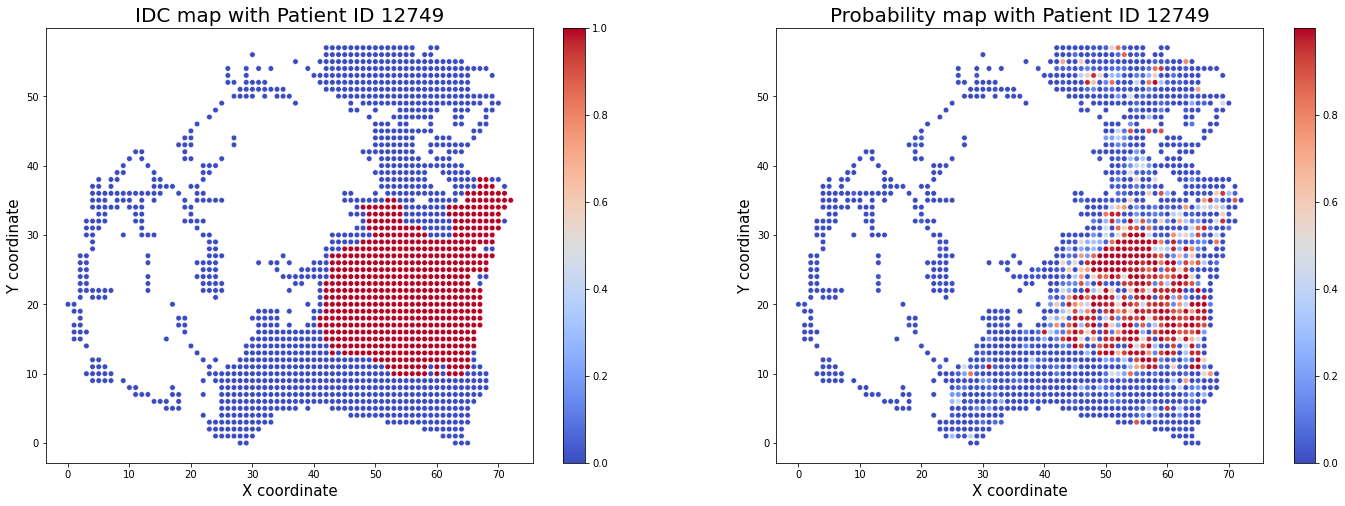

In [24]:
mini_grid, x_max, y_max = make_minimap(y_pred, plot = True)

## 2) Adjusting probability map

**In the probability distribution map, the probability distribution is concentrated by increasing the overall probability value in areas with high IDC probability.**
- In the probability map, a patch with a probability of 0.5 or higher is searched by sequentially passing from the coordinates (0, 0).
- All patches around the patch (within a certain radius) with probability greater than or equal to 0.5 are increased by the current patch probability multiplied by the rate.
- Since each coordinate is visited sequentially, it prevents the probability value from changing during the adjustment, copy the probability map before adjustment, and add the adjusted probability value to the copied probability map. After all the coordinates are adjusted, then apply to original map.
- The above process is repeated for a certain number of times so that the probability map is concentrated at the center of a high density region.
- After adjustment, normalization is performed by setting the maximum probability value to 1 in order to set the probability value between 0 and 1.

In [25]:
def adjust_probability(df, x_max, y_max, times = 5, criterion = 0.5, rate = 0.1, bound = 1, n_bins = 5, plot = False):
    
    if plot:
        min_times = min(5, times)
        steps = np.rint(np.linspace(1, times, min_times))
        fig, axes = plt.subplots(1, min_times, figsize = (6*min_times, 6), sharey = True)
        pos = 0

    for t in range(times):
        prob_data = df.copy()
        for x in range(x_max + 1):
            for y in range(y_max + 1):
                if df.at[(x, y), 'probability'] > criterion:
                    for i in range(-bound, bound):
                        for j in range(-bound, bound):
                            if x + i >= 0 and x + i < x_max + 1 and y + j >= 0 and y + j < y_max and df.at[(x + i, y + j), 'probability'] != -1:
                                df.at[(x + i, y + j), 'probability'] += prob_data.at[(x, y), 'probability'] * rate

        if plot and (t + 1) in steps:
            df.reset_index(inplace = True)
            Pred = df[df['probability'] != -1]
            df.set_index(['x', 'y'], inplace = True)

            x, y = np.mgrid[slice(0, x_max + 1, 1), slice(0, y_max + 1, 1)]
            z = df['probability'].values.reshape(x.shape)
            levels = MaxNLocator(nbins = n_bins).tick_values(z.min(), z.max())
            cmap = plt.get_cmap('viridis')

            im = axes[pos].pcolormesh(x, y, z, shading = 'gouraud', cmap = cmap, vmin = 0, vmax = z.max())
            axes[pos].contour(x, y, z, levels = levels)
            axes[pos].set_title("Step num: " + str(int(steps[pos])), fontsize = 20)
            axes[pos].set_xlabel("X coordinate", fontsize = 15)
            pos += 1
            
    if plot:
        divider = make_axes_locatable(axes[-1])
        cax = divider.append_axes('right', size = '7%', pad = 0.05)
        cbar = plt.colorbar(im, cax = cax, cmap = cmap, ticks = [0, z.max()/2, z.max()])
        cbar.ax.set_yticklabels(['Low', 'Medium', 'High'])
        axes[0].set_ylabel("Y coordinate", fontsize = 15)
        fig.tight_layout()
    
    # Normalization
    Pred = df[df['probability'] != -1].reset_index()
    minmax_scale(Pred['probability'], copy = False)
    Pred.set_index(['index'], inplace = True)

    return Pred

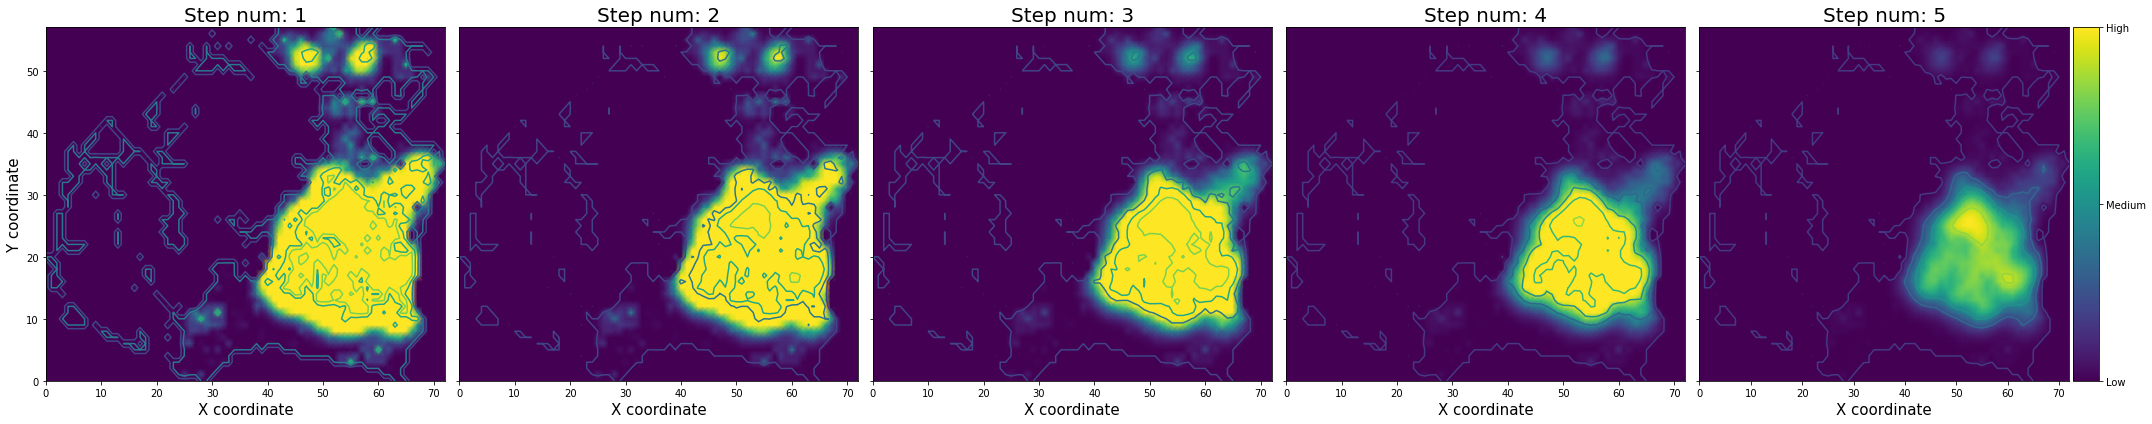

In [26]:
adj_map = adjust_probability(df = mini_grid.copy(), x_max = x_max, y_max = y_max, times = 5, criterion = 0.5, rate = 0.05, bound = 2, n_bins = 5, plot = True)

The closer to yellow, the higher the probability of IDC.  
In the early stage, it can be observed that there are places with high IDC probability in other parts besides the dense IDC area. (The dots in the leftmost photo)  
As you go through the adjustment step by step, you can see that the singularities outside the dense area of the IDC probability gradually disappear and a smooth distribution map is formed.  
**Through this, it is possible to enhance the region with high IDC prediction probability and increase the accuracy by eliminating outliers in other regions.**

## Checking the adjusted probability map and performance scores
After adjustment, the performance is compared through precision, recall, f1-score, and accuracy.  
Also, compare the probabilistic images before and after adjustment.


In [27]:
adj_y_pred = y_pred.copy()

adj_y_pred.loc[adj_map.index, 'probability'] = adj_map.loc[:, 'probability']
sample_id = y_pred.at[adj_map.index[0], 'ID']

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1199
           1       0.89      0.56      0.69       563

    accuracy                           0.84      1762
   macro avg       0.86      0.76      0.79      1762
weighted avg       0.84      0.84      0.83      1762



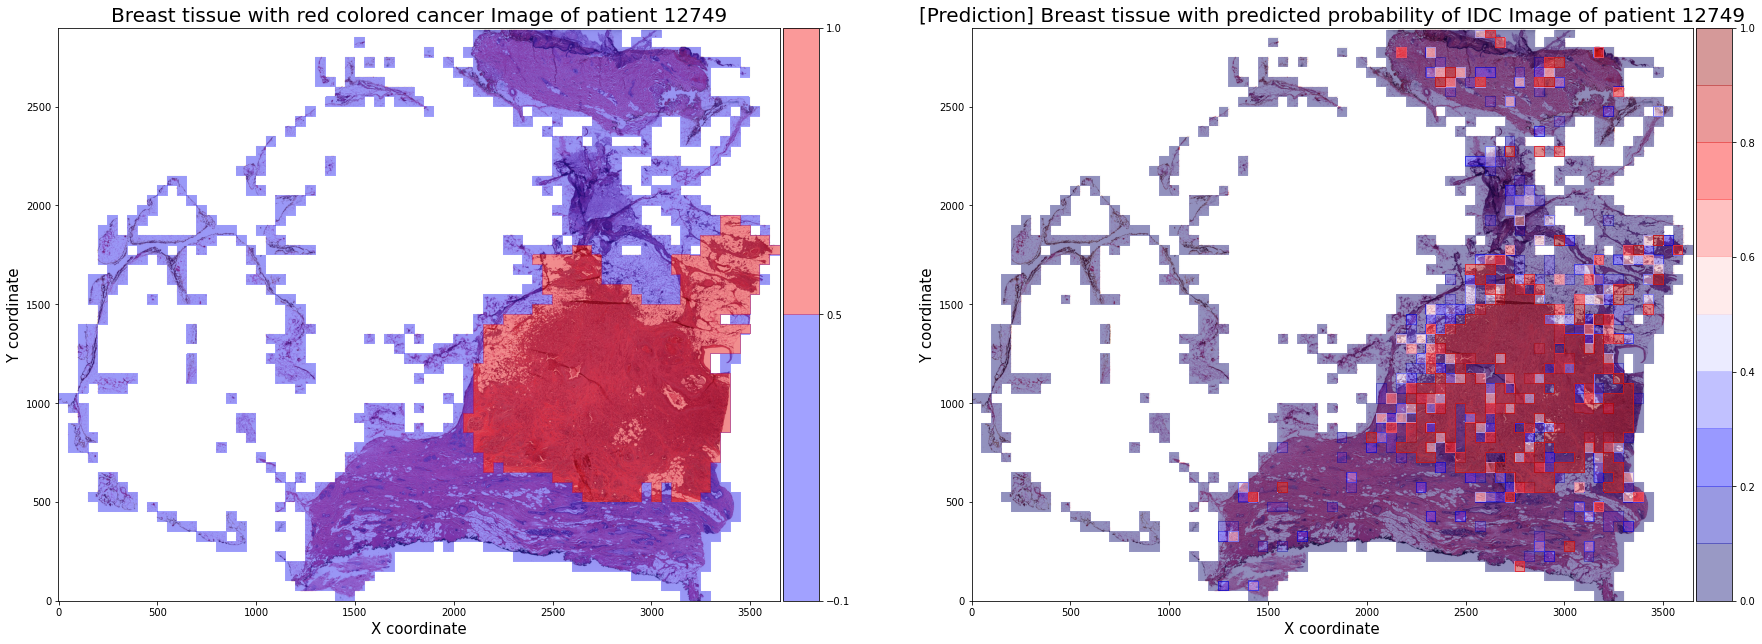

In [28]:
whole_slice_image(y_pred, patient_id = [sample_id], pred = True)
y_true = y_pred[y_pred['ID'] == sample_id]['cancer']
y_prediction = tf.round(y_pred[y_pred['ID'] == sample_id]['probability'])
print(classification_report(y_true, y_prediction))

              precision    recall  f1-score   support

           0       0.83      1.00      0.90      1199
           1       1.00      0.55      0.71       563

    accuracy                           0.86      1762
   macro avg       0.91      0.78      0.81      1762
weighted avg       0.88      0.86      0.84      1762



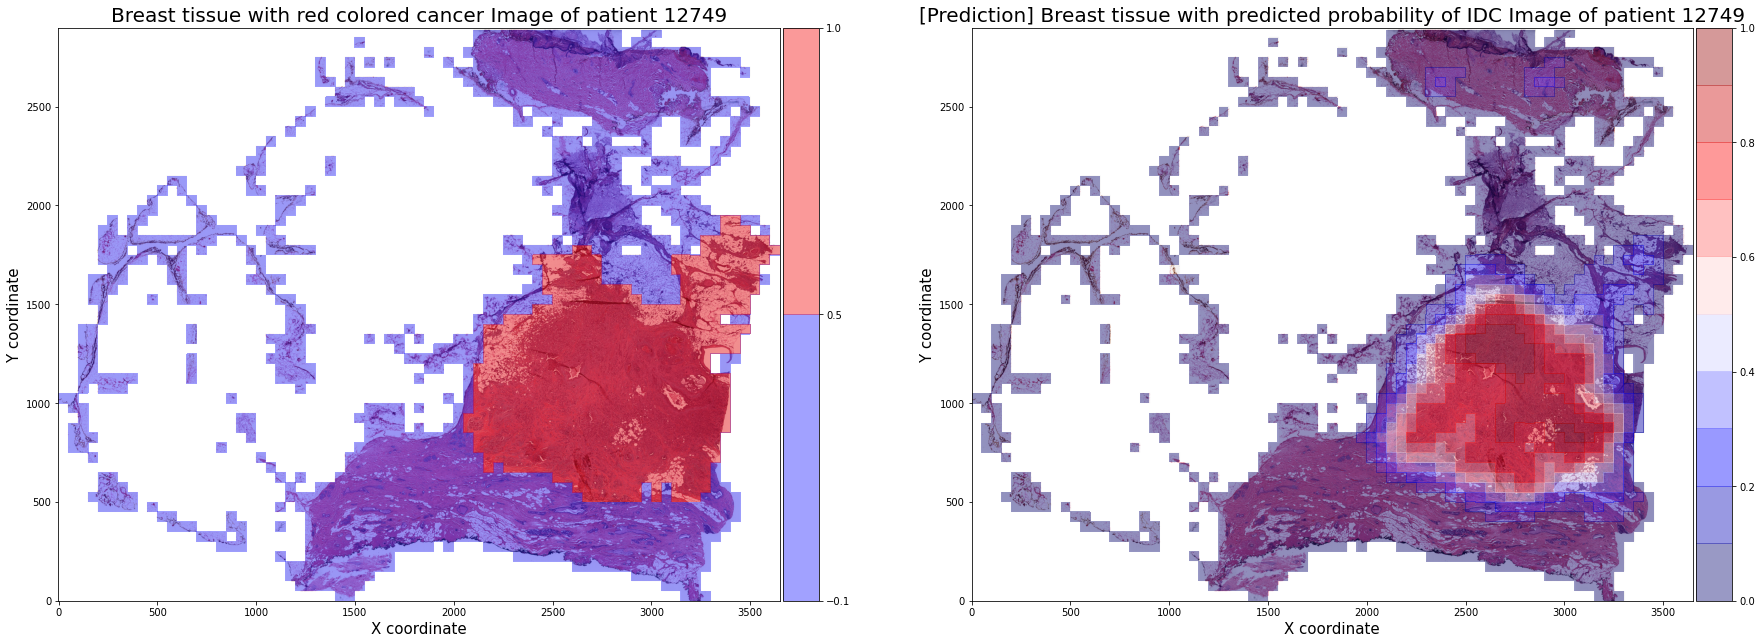

In [29]:
whole_slice_image(adj_y_pred, patient_id = [sample_id], pred = True)
y_prediction = tf.round(adj_y_pred[adj_y_pred['ID'] == sample_id]['probability'])
print(classification_report(y_true, y_prediction))

After adjusting the probability, it showed higher performance in all aspects of precision, recall, f1-score, and accuracy.  
In addition, the existing distributed probability map seems to target a specific region neatly.  
Now it is time to see if the accuracy is improved overall, not just in a specific patient sample.

### The whole process of adjustment
Perform the same adjustments for the data of all patients used in the testing dataset.  
(At this time, the rate was reduced to 0.05 because certain samples may be oversimplified.)

In [30]:
def adjustment(df, test_ids, times = 5, criterion = 0.5, rate = 0.1, bound = 1, n_bins = 5):
    adj_df = df.copy()
    for patient_id in test_ids:
        mini_grid, x_max, y_max = make_minimap(df = df, patient_id = [patient_id])
        adjusted_map = adjust_probability(df = mini_grid, x_max = x_max, y_max = y_max, times = times, criterion = criterion, rate = rate, bound = bound, n_bins = n_bins)
        adj_df.loc[adjusted_map.index, 'probability'] = adjusted_map.loc[:, 'probability']
    return adj_df

adjusted_y_pred = adjustment(y_pred, test_ids, times = 5, criterion = 0.5, rate = 0.05, bound = 2, n_bins = 5)

## Comparing model prediction performance before and after adjustment
After adjusting the probability distribution, the prediction accuracy improved.  
That is, the adjustment of the probability distribution not only significantly affects the targeting of IDC locations, but also contributes to improving the accuracy.

In [31]:
y_true = y_pred['cancer']
y_prediction = tf.round(y_pred['probability'])
print(classification_report(y_true, y_prediction))


y_adj_prediction = tf.round(adjusted_y_pred['probability'])
print(classification_report(y_true, y_adj_prediction))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      9008
           1       0.78      0.65      0.71      3393

    accuracy                           0.85     12401
   macro avg       0.83      0.79      0.81     12401
weighted avg       0.85      0.85      0.85     12401

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      9008
           1       0.93      0.65      0.77      3393

    accuracy                           0.89     12401
   macro avg       0.91      0.82      0.85     12401
weighted avg       0.90      0.89      0.89     12401



## Comparing probability map before and after adjustment
Before the adjustment, the prediction distribution was sporadically spread, but after adjustment, it became denser near the IDC area and changed gently.

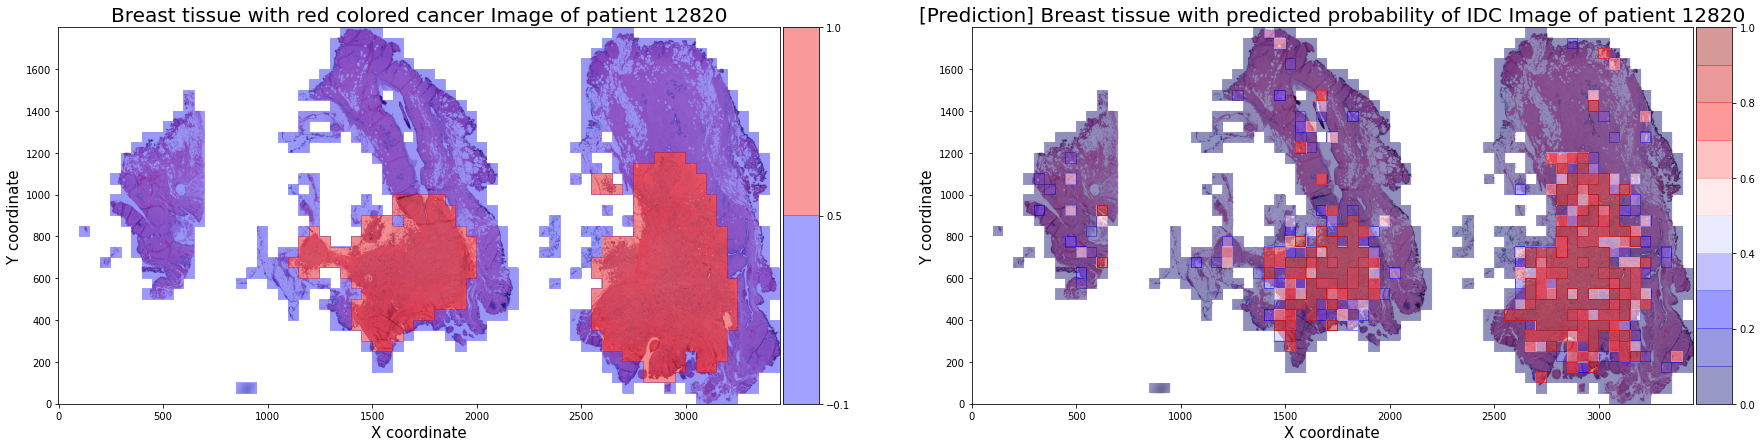

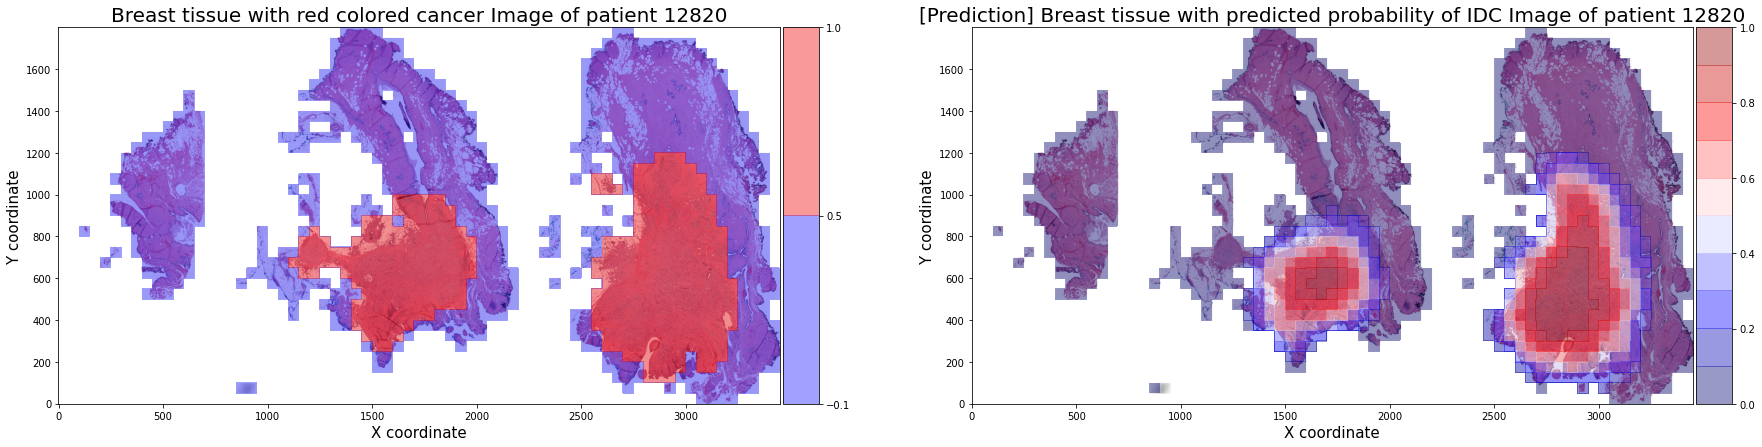

In [32]:
def compare_adjusted_probability_image(df, adjusted_df, test_ids, all = False):
    sample_id = np.random.choice(test_ids, size = 1, replace = False)
    whole_slice_image(df, patient_id = [sample_id[0]], pred = True)
    whole_slice_image(adjusted_df, patient_id = [sample_id[0]], pred = True)

compare_adjusted_probability_image(y_pred, adjusted_y_pred, test_ids)

# 7. Conclusion
**1) Model learning and prediction**
- (EfficientNetB2 - FC256 - FC128 - FC64) was used as a deep learning model for IDC prediction.
- In training, the accuracy was up to 93%, and the prediction accuracy through the test data was 86%.
- Therefore, we succeeded in implementing a deep learning model with a high accuracy of approximately 80% to 90%.

**2) Changing by adjusting the probability map**
- Since prediction through learning is made individually for each patch image, the probability map adjustment was performed to solve the problem that the IDC prediction map appeared distributedly.
- After adjusting the probability map, the accuracy of the entire testing dataset in the project increased from 86% to 91%.
- In addition, it was possible to observe that IDC targeting for a specific region was changed more neatly and reliably in the actual probability map.
- As a result, I succeeded in implementing a model for IDC targeting.

# 8. Discussion
**1) Improve the performance of the model**  
In this project, a large amount of data could not be used for training due to memory limitations. Therefore, it is expected that if a larger amount of data is used for training, a model with higher prediction accuracy than now can be created. It is expected that it will be commercially available if the prediction accuracy is further improved by fine-tuning hyperparameters along with more training data.

**2) Improving the probability adjustment step**  
In this project, the most painstaking probability adjustment step requires optimization in terms of time and memory because it is made by hand rather than using a method existing in a specific module or package. Also, since the initial probability adjustment criterion is applied only in the first step, if the prediction of the IDC model is concentrated on a region other than the actual IDC or the actual IDC region has a significantly low probability distribution, this problem cannot be solved in the probability adjustment stage. In other words, it is highly likely that the desired result may not be obtained when applied to a model with low prediction accuracy because it concentrates the prediction area of the model rather than correcting and improving the model's erroneous prediction. However, if the probability adjustment step is applied to a model with a certain level of accuracy (approximately 80% to 90%), it will be of great help in improving the accuracy and the probability image.

**3) Scalability**  
Although the project focused on the prediction of IDC based on breast histopathology images, it can be used to find targets in most tissues with visually distinguishable features. Since it can be used for targeting to various diseases, it can be considered to have excellent commercial potential.

# 9. Data source and references  
## Data source
- https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images

## Reference
**1)**  https://www.kaggle.com/code/allunia/breast-cancer  
**2)**  https://www.healthline.com/health/invasive-ductal-carcinoma-treatment#symptoms  
**3)**  Bouvier AS, Panchbhaya N, Brochard C, Marchand E, Mezzadri M, Leveau-Vallier AS, Cornelis F, Benifla JL, Mimoun C. Uterine metastasis from invasive ductal breast carcinoma: A case report with literature review. J Gynecol Obstet Hum Reprod. 2021 Jan;50(1):101993. doi: 10.1016/j.jogoh.2020.101993. Epub 2020 Nov 17. PMID: 33217599.  
**4)**  Janowczyk A, Madabhushi A. Deep learning for digital pathology image analysis: A comprehensive tutorial with selected use cases. J Pathol Inform. 2016 Jul 26;7:29. doi: 10.4103/2153-3539.186902. PMID: 27563488; PMCID: PMC4977982.  
**5)**  Cruz-Roa A, Gilmore H, Basavanhally A, Feldman M, Ganesan S, Shih N, et al. (2018) Highthroughput adaptive sampling for whole-slide histopathology image analysis (HASHI) via convolutional neural networks: Application to invasive breast cancer detection. PLoS ONE 13(5): e0196828. https://doi.org/10.1371/journal. pone.0196828  
**6)**  Angel Cruz-Roa, Ajay Basavanhally, Fabio González, Hannah Gilmore, Michael Feldman, Shridar Ganesan, Natalie Shih, John Tomaszewski, Anant Madabhushi, "Automatic detection of invasive ductal carcinoma in whole slide images with convolutional neural networks," Proc. SPIE 9041, Medical Imaging 2014: Digital Pathology, 904103 (20 March 2014); https://doi.org/10.1117/12.2043872  